In [3]:
import mat73
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import json

FILE_TRAIN             = "train.npz"
FILE_SPLIT             = "train_split.json"
FILE_TRAIN_PCA         = "train_pca.npz"
FILE_TRAIN_AUTOENCODER = "train_autoencoder.npz"

def create_training(mat_file="data_for_python.mat"):
    data = mat73.loadmat(mat_file)
    
    nsub = len(data['data']['eeg'])
    nchannels = data['data']['eeg'][0]['trial'][0].shape[0]
    ntime = max([data['data']['eeg'][sno]['trial'][tno].shape[1]  
                    for sno in range(nsub) for tno in range(len(data['data']['eeg'][sno]['trial']))])
    ntottrials = sum([len(data['data']['eeg'][sno]['trial']) 
                        for sno in range(nsub)])
    input = np.full((ntottrials, ntime, nchannels), np.nan)

    resp = np.full((ntottrials), np.nan, "uintc")
    conf = np.full((ntottrials), np.nan, "uintc")
    correct = np.full((ntottrials), np.nan, "uintc")
    sub = np.full((ntottrials), np.nan, "uintc")
    condition = np.full((ntottrials), np.nan, "object")
    ctrain = 0
    for sno in range(nsub):
        ctrain_sub_start = ctrain 
        for tno in range(len(data['data']['eeg'][sno]['trial'])):
            this_ntime = data['data']['eeg'][sno]['trial'][tno].shape[1]
            input[ctrain,0:this_ntime,:] = data['data']['eeg'][sno]['trial'][tno].T
            resp[ctrain] = 0 if data['data']['confidence'][sno][tno] <= 3 else 1
            conf[ctrain] = (data['data']['confidence'][sno][tno] if data['data']['confidence'][sno][tno] <= 3 else 7 - data['data']['confidence'][sno][tno]) - 1
            correct[ctrain] = data['data']['correct'][sno][tno]
            sub[ctrain] = sno
            condition[ctrain] = data['data']['condition'][sno][tno][0]
            ctrain += 1
    
    np.savez(FILE_TRAIN, input=input, resp=resp, conf=conf, correct=correct, sub=sub, condition=condition)

    return {'input': input, 'resp': resp, 'conf': conf, 'correct': correct, 'sub': sub, 'condition': condition}

def split():
    data = np.load(FILE_TRAIN, allow_pickle=True)

    nsub = np.max(data['sub']) + 1
    all_idx_train = []
    all_idx_valid = []

    for sno in range(nsub):
        idx_train, idx_valid = train_test_split(np.arange(np.sum(data['sub'] == sno)), test_size=0.2)
        all_idx_train.append(idx_train.tolist())
        all_idx_valid.append(idx_valid.tolist())

    with open(FILE_SPLIT, "w") as f:
        json.dump({'all_idx_train': all_idx_train, 'all_idx_valid': all_idx_valid}, f)

def lstm_autoencoder_dim_reduce():
    data = np.load(FILE_TRAIN, allow_pickle=True)
    with open(FILE_SPLIT, "r") as f:
        split = json.load(f)

    nsub = np.max(data['sub']) + 1
    
    input = data['input']
    input[np.isnan(input)] = 0

    ncomponents = 10
    reduced_input = np.full((input.shape[0], ncomponents), np.nan)

    ### FOR EXPLORING INDIVIDUAL PARTICIPANTS:
    #sno = 1
    #input = data['input'][data['sub'] == sno, :, :]
    #input[np.isnan(input)] = 0
    #input = StandardScaler().fit_transform(input)
    ## Build autoencoder.
    #layer_input = keras.Input(shape=input.shape[1:3])
    #x = keras.layers.LSTM(ncomponents)(layer_input)
    #bottleneck = x
    #x = keras.layers.RepeatVector(input.shape[1])(x)
    #x = keras.layers.LSTM(ncomponents, return_sequences=True)(x)
    #x = keras.layers.TimeDistributed(keras.layers.Dense(input.shape[2]))(x)
    #layer_output = x
    ## Fit.
    #autoencoder = keras.Model(layer_input, layer_output)
    #autoencoder.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError())
    #autoencoder.summary()
    #autoencoder.fit(x=input, y=input, validation_split=0.2, batch_size=32, epochs=200)
    ## See how well we did on all of the data.
    #reconstructed = autoencoder.predict(input)
    #plt.plot(np.nanmean(input[:,:,0], axis=0), linewidth=2.0)
    #plt.plot(np.nanmean(reconstructed[:,:,0], axis=0), linewidth=2.0)
    #plt.show()
    ##
    #plt.plot(input[200,:,0], linewidth=2.0)
    #plt.plot(reconstructed[200,:,0], linewidth=2.0)
    #plt.show()

    for sno in range(nsub):
        print("## PARTICIPANT: {}\n\n\n".format(sno))
        input_sub = input[data['sub'] == sno, :, :]

        input_sub_train = input_sub[split['all_idx_train'][sno], :]
        input_sub_valid = input_sub[split['all_idx_valid'][sno], :]

        # z-score (requires temporarily collapsing time and channels dimensions).
        train_shape = input_sub_train.shape
        valid_shape = input_sub_valid.shape
        input_sub_train = np.reshape(input_sub_train, (input_sub_train.shape[0], input_sub_train.shape[1]*input_sub_train.shape[2]), order="C")
        input_sub_valid = np.reshape(input_sub_valid, (input_sub_valid.shape[0], input_sub_valid.shape[1]*input_sub_valid.shape[2]), order="C")
        scale = StandardScaler()
        scale.fit(input_sub_train)
        input_sub_train = scale.transform(input_sub_train)
        input_sub_valid = scale.transform(input_sub_valid)
        input_sub_train = np.reshape(input_sub_train, train_shape, order="C")
        input_sub_valid = np.reshape(input_sub_valid, valid_shape, order="C")

        # Build autoencoder.
        layer_input = keras.Input(shape=input_sub.shape[1:3])
        x = keras.layers.LSTM(ncomponents)(layer_input)
        bottleneck = x
        x = keras.layers.RepeatVector(input_sub.shape[1])(x)
        x = keras.layers.LSTM(ncomponents, return_sequences=True)(x)
        x = keras.layers.TimeDistributed(keras.layers.Dense(input_sub.shape[2]))(x)
        layer_output = x

        # Fit.
        autoencoder = keras.Model(layer_input, layer_output)
        autoencoder.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError())
        autoencoder.summary()
        autoencoder.fit(x=input_sub_train, y=input_sub_train, batch_size=32, epochs=200)

        # Store encoded representation.
        encoder = keras.Model(layer_input, bottleneck)
        reduced_input_sub = np.full((input_sub.shape[0], ncomponents), np.nan)
        reduced_input_sub[split['all_idx_train'][sno],:] = encoder.predict(input_sub_train)
        reduced_input_sub[split['all_idx_valid'][sno],:] = encoder.predict(input_sub_valid)
        reduced_input[data['sub'] == sno, :] = reduced_input_sub

    np.savez(FILE_TRAIN_AUTOENCODER, reduced_input=reduced_input, resp=data['resp'], conf=data['conf'], correct=data['correct'], sub=data['sub'], condition=data['condition'])

def pca_dim_reduce():
    data = np.load(FILE_TRAIN, allow_pickle=True)
    with open(FILE_SPLIT, "r") as f:
        split = json.load(f)

    nsub = np.max(data['sub']) + 1

    # Reshape the input to be trials x (channels x time).
    input = data['input']
    input = np.moveaxis(input, -1, 1)
    input = np.reshape(input, (input.shape[0], input.shape[1]*input.shape[2]), order="C")
    input[np.isnan(input)] = 0

    ### FOR EXPLORING INDIVIDUAL PARTICIPANTS:
    # Perform PCA and plot variance explained.
    sno = 0
    input = input[data['sub'] == sno, :]
    pca = PCA(20)
    input_pca = pca.fit_transform(StandardScaler().fit_transform(input))
    plt.plot(np.arange(pca.n_components_) + 1, pca.explained_variance_ratio_, 'o-', linewidth=2)
    plt.xticks(np.arange(pca.n_components_) + 1)
    plt.show()
    ###

    ncomponents = 10
    reduced_input = np.full((input.shape[0], ncomponents), np.nan)

    for sno in range(nsub):
        input_sub = input[data['sub'] == sno, :]
        
        input_sub_train = input_sub[split['all_idx_train'][sno], :]
        input_sub_valid = input_sub[split['all_idx_valid'][sno], :]

        # Compute PCA transformation based on training data only, apply to both.
        pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(ncomponents))])
        pipe.fit(input_sub_train)
        reduced_input_sub = np.full((input_sub.shape[0], ncomponents), np.nan)
        reduced_input_sub[split['all_idx_train'][sno],:] = pipe.transform(input_sub_train)
        reduced_input_sub[split['all_idx_valid'][sno],:] = pipe.transform(input_sub_valid)

        reduced_input[data['sub'] == sno, :] = reduced_input_sub

    np.savez(FILE_TRAIN_PCA, reduced_input=reduced_input, resp=data['resp'], conf=data['conf'], correct=data['correct'], sub=data['sub'], condition=data['condition'])


ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB

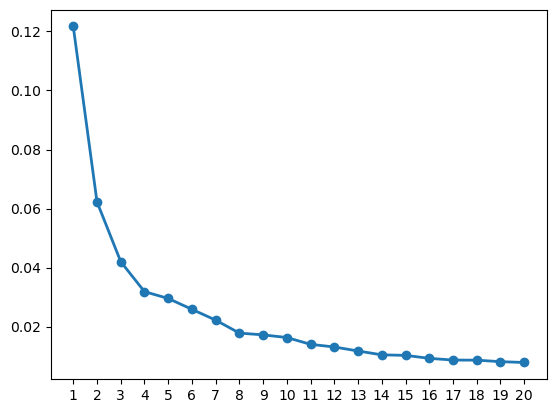

IndexError: boolean index did not match indexed array along dimension 0; dimension is 756 but corresponding boolean dimension is 15653

In [4]:
create_training()
split()
pca_dim_reduce()
